# CountGPVAE Simulation Demo

This notebook demonstrates how to use the modularized components of the CountGPVAE model.

In [1]:
import os
import jax
import jax.nn as nn
import math
import itertools
from jax import lax, random
from jax.example_libraries import stax
import jax.numpy as jnp
from jax.random import PRNGKey
import numpy as np
import numpyro
import pickle
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, RenyiELBO
import arviz as az
import sys
from pyprojroot import here
import time
import plotly.express as px
import geopandas as gpd
sys.path.append(str(here() / "simulation study" / "src"))
# Import our modular components
from kernels import exp_sq_kernel, M_g
from loader_jkt import load_data
from gp import gp_aggr
from vae import vae_model, vae_guide, vae_decoder
from plotting import plot_process, plot_incidence_map
import matplotlib.pyplot as plt
from numpyro.infer import NUTS, MCMC, Predictive, init_to_median, init_to_uniform, init_to_sample, init_to_mean, init_to_value

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data

In [2]:
# Load the spatial grid and polygon data
spatial_data = load_data()
print(spatial_data.keys())

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])


## 2. Set up Model Parameters

In [3]:
# Model configuration
args = {
    "x": spatial_data["x"],
    "gp_kernel": exp_sq_kernel,
    "noise": 1.e-2,
    "jitter": 1.e-2,
    "M_lo": jnp.array(spatial_data["pol_pts_lo"]),
    "M_hi":  jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    "vae_var": 0.1,
    "batch_size": 100,
    "hidden_dim": 50,
    "z_dim": 40,
    "learning_rate": 1e-3,
    "num_epochs": 30,
    "rng_key": PRNGKey(6)
}

## 3. Generate GP Samples

In [35]:
# Create predictive function for GP
from numpyro.infer import Predictive
# Draw samples from the prior
prior_samples = Predictive(gp_aggr, num_samples=5)(
    PRNGKey(6),
    config=args
)

# transform prior samples to arviz inference object
prior_samples_arviz = az.from_numpyro(prior=prior_samples)

plot_process(prior_samples_arviz.prior.gp_aggr.values)

## 4. Train VAE

In [115]:
# Initialize SVI
optimizer = numpyro.optim.Adam(step_size=1e-3)
agg_gp_predictive = Predictive(gp_aggr,num_samples = 5)
@jax.jit
def epoch_train(rng_key, svi_state, num_train):
    def body_fn(i, val):
        rng_key_i = jax.random.fold_in(rng_key, i) #Array(2,)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = jax.random.split(rng_key_i, 4) #Tuple(Array(2,) x 4)
        loss_sum, svi_state = val #val --svi_state

        batch = agg_gp_predictive(rng_key_i, args)["gp_aggr"] #(5,116) <- num_samples : 5, total_districts : 116
        #* svi is where the vae_model & vae_guide gets applied
        svi_state, loss = svi.update(svi_state, batch)
        loss_sum += loss / args["batch_size"]
        return loss_sum, svi_state

    return lax.fori_loop(lower = 0, upper = num_train, body_fun=body_fn, init_val=(0.0, svi_state))

@jax.jit
def eval_test(rng_key, svi_state, num_test):
    def body_fn(i, loss_sum):
        rng_key_i = jax.random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_varm, rng_key_noise = jax.random.split(rng_key_i, 4)
        batch = agg_gp_predictive(rng_key_i, args)["gp_aggr"]
        #* svi is where the vae_model & vae_guide gets applied
        loss = svi.evaluate(svi_state, batch) / args["batch_size"]
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(lower = 0, upper = num_test,body_fun =  body_fn, init_val = 0.0)
    loss = loss / num_test
    return loss

## Hyerparameter tuning for h and z

In [16]:
# Define hyperparameter grid
hidden_dims = [20, 30, 40, 50]
z_dims = [20, 30, 40, 50]

# Store results
test_loss_results_final = {}
test_loss_results_mean = {}

num_train = 100
num_test = 100
num_epochs = 20

for hidden_dim, z_dim in itertools.product(hidden_dims, z_dims):
    print(f"Training with hidden_dim={hidden_dim}, z_dim={z_dim}")

    args["hidden_dim"] = hidden_dim
    args["z_dim"] = z_dim

    # Initialize optimizer and SVI
    adam = numpyro.optim.Adam(step_size=args["learning_rate"])
    # Pass vae_var to vae_model using a lambda function
    svi = SVI(
        lambda batch: vae_model(batch, hidden_dim, z_dim, args["vae_var"]),
        lambda batch: vae_guide(batch, hidden_dim, z_dim),
        adam,
        RenyiELBO(),
    )

    # Split RNG keys
    rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
    init_batch = agg_gp_predictive(rng_key_samp, args)["gp_aggr"]

    # Initialize SVI state
    svi_state = svi.init(rng_key_init, init_batch)

    # Pre-allocate test loss array
    test_loss_list = jnp.zeros(num_epochs)

    # Training loop
    for epoch in range(num_epochs):
        rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)
        t_start = time.time()

        train_loss, svi_state = epoch_train(rng_key_train, svi_state, num_train)
        test_loss = eval_test(rng_key_test, svi_state, num_test)
        test_loss_list = test_loss_list.at[epoch].set(test_loss)

        print(f"Epoch: {epoch}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f} ({time.time() - t_start:.2f} s)")

        if math.isnan(test_loss):  # Stop early if NaN
            print(f"NaN encountered at hidden_dim={hidden_dim}, z_dim={z_dim}. Skipping...")
            break  # Stop training if NaN occurs

    # Store results only if valid
    if not math.isnan(test_loss_list[-1]):
        test_loss_results_final[(hidden_dim, z_dim)] = test_loss_list[-1]
        test_loss_results_mean[(hidden_dim, z_dim)] = jnp.nanmean(test_loss_list)
        print(f"Final Test loss for hidden_dim={hidden_dim}, z_dim={z_dim}: {test_loss_list[-1]}")
        print(f"Mean Test loss for hidden_dim={hidden_dim}, z_dim={z_dim}: {jnp.nanmean(test_loss_list)}")

print("Grid search complete.")
print("Results:", test_loss_results_final)
print("Mean Test Loss Results:", test_loss_results_mean)

Training with hidden_dim=20, z_dim=20


KeyboardInterrupt: 

### Optimal hyperparams with lowest mean test loss and pretty stable final loss is (50, 30)

In [ ]:
#-------------------------- Train VAE -------------------------- #
run = True
if run:
    adam = numpyro.optim.Adam(step_size = args["learning_rate"])
    svi = SVI(
        model=lambda batch: vae_model(batch, args["hidden_dim"], args["z_dim"], args["vae_var"]),
        guide=lambda batch: vae_guide(batch, args["hidden_dim"], args["z_dim"]),
        optim=adam,
        loss=RenyiELBO(),
    )
    rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"],3)
    #(num_samples, num_regions)
    init_batch = agg_gp_predictive(rng_key_samp, args)["gp_aggr"] #(num_samples, num_regions) <- i.e (5,58)
    svi_state = svi.init(rng_key_init, init_batch)

    test_loss_list = []

    for i in range(args["num_epochs"]):
        rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)
        t_start = time.time()
        num_train = 1000
        # Where forward/backward pass gets called for train
        train_loss , svi_state = epoch_train(rng_key_train, svi_state, num_train)
        num_test = 1000
        # Where forward/backward pass gets called for test
        test_loss = eval_test(rng_key_test, svi_state, num_test)
        test_loss_list += [test_loss]

        print("Epoch : {}, train loss : {:.2f}, test loss : {:.2f} ({:.2f} s.)".format(i, train_loss, test_loss, time.time() - t_start))
        if np.isnan(test_loss):
            break

Epoch : 0, train loss : 62461775872.00, test loss : 3613909.75 (0.00 s.)
Epoch : 1, train loss : 2129245312.00, test loss : 1725565.12 (0.00 s.)
Epoch : 2, train loss : 1460391808.00, test loss : 1073098.50 (0.00 s.)
Epoch : 3, train loss : 560378112.00, test loss : 146569.41 (0.00 s.)
Epoch : 4, train loss : 72361448.00, test loss : 32610.39 (0.00 s.)
Epoch : 5, train loss : 32149790.00, test loss : 34360.36 (0.00 s.)
Epoch : 6, train loss : 32413850.00, test loss : 31477.86 (0.00 s.)
Epoch : 7, train loss : 27511496.00, test loss : 26221.64 (0.00 s.)
Epoch : 8, train loss : 28911178.00, test loss : 26865.74 (0.00 s.)
Epoch : 9, train loss : 27171366.00, test loss : 26099.65 (0.00 s.)
Epoch : 10, train loss : 28542736.00, test loss : 29742.70 (0.00 s.)
Epoch : 11, train loss : 28341240.00, test loss : 26945.03 (0.00 s.)
Epoch : 12, train loss : 27274382.00, test loss : 26384.37 (0.00 s.)
Epoch : 13, train loss : 29153156.00, test loss : 28928.93 (0.00 s.)
Epoch : 14, train loss : 2866

In [ ]:
vae_params = svi.get_params(svi_state)

In [ ]:
save_dir = "/content/model_weights/aggVAE"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"aggVAE_e{args['num_epochs']}_h{args['hidden_dim']}_z{args['z_dim']}_batch{args["batch_size"]}.pkl")

with open(save_path, "wb") as file:
    pickle.dump(vae_params, file)

print(f"VAE parameters saved to {save_path}")

VAE parameters saved to /content/model_weights/aggVAE/aggVAE_e50_h50_z30.pkl


## Run MCMC using trained VAE encoder

In [4]:
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [5]:
N = 6

def vae_sample(args):
    dec_params = args["decoder_params"]
    z_dim, h_dim = dec_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    dec_init_fn, dec_apply_fn = vae_decoder(h_dim, N)
    x_recon = dec_apply_fn(dec_params, z)
    vae_aggr = numpyro.deterministic("vae_aggr", x_recon)
    return vae_aggr

rng_key, rng_key_predict = random.split(random.PRNGKey(3))
vae_predictive = Predictive(vae_sample, num_samples = 5)
vae_draws = vae_predictive(rng_key_predict, args)["vae_aggr"]

In [ ]:
plot_process(jnp.expand_dims(vae_draws, axis = 0))

In [6]:
# ------------------- Func for Agg VAE Prev ------------------- #
def prev_model_vae_aggr(config=None):

    if config is None:
        config = {}

    # Set defaults
    x = config.get('x', None)
    gp_kernel = config.get('gp_kernel', exp_sq_kernel)
    noise = config.get('noise', 1e-4)
    jitter = config.get('jitter', 1e-4)
    M_lo = config.get('M_lo', None)
    M_hi = config.get('M_hi', None)
    kernel_length_prior = config.get('kernel_length', dist.InverseGamma(4, 1))
    kernel_var_prior = config.get('kernel_var', dist.LogNormal(0, 0.1))
    pop_density = config.get('pop_density', None)
    urban_frac = config.get('urban_frac', None)
    hdi_index = config.get('hdi_index', None)
    count = config.get("count", None)

     # Total cases: pass in low prev counts, mask high prev ones as NaN
    count_mask = ~jnp.isnan(count)

    total_population = config.get('total_population', None)
    is_prior_pred = config.get('prior_pred', False)
    out_dims = config.get('out_dims', 6)
    # GP
    config_gp = config.copy()
    config_gp['x'] = x
    config_gp['gp_kernel'] = gp_kernel
    config_gp['noise'] = noise
    config_gp['jitter'] = jitter
    config_gp['M_lo'] = M_lo
    config_gp['M_hi'] = M_hi
    config_gp['kernel_length'] = kernel_length_prior
    config_gp['kernel_var'] = kernel_var_prior
    # Call gp_aggr
    decoder_params = config["decoder_params"]
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    _, decoder_apply = vae_decoder(hidden_dim, out_dims) #Instantiate decoder
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_apply(decoder_params, z))
    s = numpyro.sample("sigma1", dist.HalfNormal(200))

    vae = numpyro.deterministic("vae", s * vae_aggr)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(100, 10))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI
    b_urban = numpyro.sample("b_urban", dist.Normal(0, 1))  # Effect of urbanicity

    # Linear predictor
    # lp = numpyro.deterministic("lp", (b0 +
    #                                   aggr_gp +
    #                                   b_pop_density * pop_density +
    #                                   b_hdi * hdi_index +
    #                                   b_urban * urban_frac))  #
    lp = numpyro.deterministic("lp", nn.softplus(b0 +
                                      vae +
                                      b_pop_density * pop_density +
                                      b_hdi * hdi_index +
                                      b_urban * urban_frac))


    sigma = numpyro.sample("sigma", dist.HalfNormal(5))

    # Full predictions (no masking)
    full_pred_cases = numpyro.sample(
        "full_pred_cases",
        dist.Normal(lp, sigma))

    # Observed only where count is available
    with numpyro.handlers.mask(mask=count_mask):
        numpyro.sample(
            "pred_cases",  # not used for return
            dist.Normal(lp, sigma),
            obs=None if is_prior_pred else count)

    # Store full predictions
    numpyro.deterministic("pred_cases_out", full_pred_cases)


In [7]:
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data
year_data = 2023
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the most recent year
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2023



In [8]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [ ]:
model =  prev_model_vae_aggr
n_samples = 1000
# Define the sampler
sampler = NUTS(model, target_accept_prob = 0.85, max_tree_depth = 20)
mcmc = MCMC(sampler,
            num_warmup=1000,
            num_samples=n_samples,
            num_chains=4,
            chain_method="vectorized",
            )
start = time.time()
#set random key to 6 for running years 2022 and 2023, and random key to 2 for running years 2020 and 2021
mcmc.run(PRNGKey(6), config_count)
end = time.time()
t_elapsed_min = round((end - start) / 60)
print(f"Time taken to run MCMC: {t_elapsed_min} minutes")

warmup:   8%|▊         | 160/2000 [1:09:57<31:26:33, 61.52s/it]

In [ ]:
#save mcmc for aggVAE jkt yearly (change the year manually)
# Save the MCMC object as a pickle file
# Define the path where you want to save the MCMC files

save_dir = "../model weights/aggVAEPrev"
os.makedirs(save_dir, exist_ok=True)

# Define the file path where to save the MCMC object
file_path = os.path.join(save_dir, f"mcmc_jkt_{year_data}_{t_elapsed_min}min_z{args["z_dim"]}_{n_samples}_prob0.85.pkl")

# Save the MCMC object as a pickle file
with open(file_path, 'wb') as f:
        pickle.dump(mcmc, f)

print(f"MCMC object for year {year_data} saved successfully at {file_path}.")

MCMC object for year 2020 saved successfully at ../model weights/aggVAEPrev\mcmc_jkt_2020_86min_z20_1000_tuned.pkl.


In [328]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.77      9.80     99.77     83.49    115.36   2482.36      1.00
             b_hdi      0.07      1.01      0.05     -1.63      1.62   1425.00      1.00
     b_pop_density      0.08      1.00      0.07     -1.67      1.66   2048.05      1.00
           b_urban      0.06      1.00      0.05     -1.59      1.69   1120.81      1.00
full_pred_cases[0]   1216.77      7.98   1216.88   1203.54   1229.52   1927.13      1.00
full_pred_cases[1]    274.03    133.15    270.33     50.83    487.39    397.99      1.00
full_pred_cases[2]    169.16    131.08    158.45    -11.09    347.88    484.94      1.00
full_pred_cases[3]    317.93    138.55    317.93     90.07    536.97    390.66      1.00
full_pred_cases[4]    405.41    139.81    405.22    186.72    616.64    373.36      1.00
full_pred_cases[5]    388.67    133.75    380.11    177.67    568.62    429.71      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1216.769,7.976,1199.842,1231.419,0.181,0.295,2215.0,1422.0,1.01
pred_cases_out[1],274.033,133.151,-7.207,478.273,6.522,5.152,416.0,590.0,1.00
pred_cases_out[2],169.158,131.080,-13.369,384.459,5.866,3.284,480.0,1002.0,1.00
pred_cases_out[3],317.935,138.554,-4.231,526.368,6.841,4.869,416.0,594.0,1.00
pred_cases_out[4],405.412,139.808,163.292,683.346,7.058,6.835,414.0,582.0,1.00
pred_cases_out[5],388.666,133.754,139.504,603.278,6.376,10.644,512.0,643.0,1.00
lp[0],1216.793,5.732,1205.773,1228.997,0.116,0.176,2698.0,1912.0,1.01
lp[1],273.955,133.087,0.000,471.599,6.526,5.161,419.0,587.0,1.00
lp[2],169.105,130.981,0.000,383.309,5.864,3.282,456.0,643.0,1.00
lp[3],317.926,138.388,0.000,517.400,6.832,4.866,417.0,583.0,1.00


In [96]:
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 1195
Average ESS for all aggVAE-low effects : 1209
Max r_hat for all aggVAE-low : 1.0
Average ESS for all aggVAE-high effects : 1192
Max r_hat for all aggVAE-high : 1.0


In [93]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

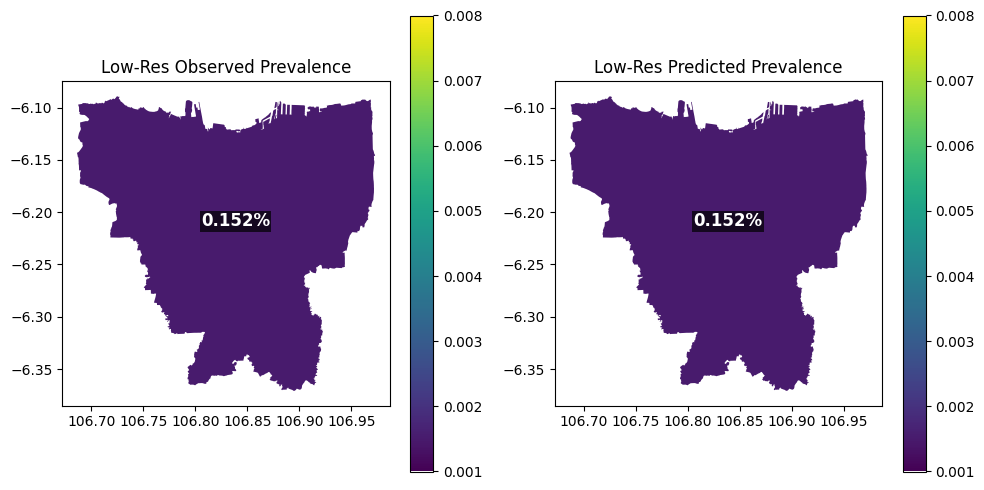

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

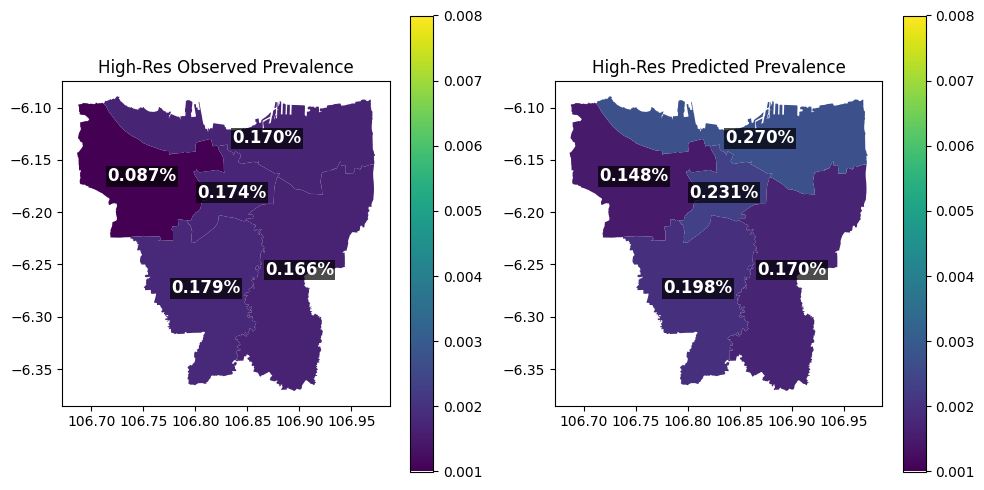

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
#save the df predictions (change the year naming convention manually)
df_hi.to_csv("../data/processed/df_hi_jkt_2020_aggVAE_preds.csv")

## MCMC Inference (see which one produces the best metric (change manually))

In [18]:
model =  prev_model_vae_aggr

In [19]:
# define concordance correlation coefficient taken from: https://github.com/stylianos-kampakis/supervisedPCA-Python/blob/master/Untitled.py
# mentioned in the github post: https://rowannicholls.github.io/python/statistics/agreement/concordance_correlation_coefficient.html; referencing these papers:Giavarina D. Understanding Bland Altman analysis. Biochemia Medica. 2015;25(2):141–51. DOI: 10.11613/BM.2015.015.
# Lin LI-K. A Concordance Correlation Coefficient to Evaluate Reproducibility. Biometrics. 1989;45(1):255-268. DOI: 10.2307/2532051. PMID: 2720055.

def concordance_correlation_coefficient(y_true, y_pred,
                       sample_weight=None,
                       multioutput='uniform_average'):
    """Concordance correlation coefficient.

    The concordance correlation coefficient is a measure of inter-rater agreement.
    It measures the deviation of the relationship between predicted and true values
    from the 45 degree angle.

    Read more: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient
    Original paper: Lawrence, I., and Kuei Lin. "A concordance correlation coefficient to evaluate reproducibility." Biometrics (1989): 255-268.  

    Parameters
    ----------
    y_true : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Ground truth (correct) target values.

    y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Estimated target values.

    Returns
    -------
    loss : A float in the range [-1,1]. A value of 1 indicates perfect agreement
    between the true and the predicted values.

    Examples
    --------
    >>> from sklearn.metrics import concordance_correlation_coefficient
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> concordance_correlation_coefficient(y_true, y_pred)
    0.97678916827853024


    """
    cor=np.corrcoef(y_true,y_pred)[0][1]
    
    mean_true=np.mean(y_true)
    mean_pred=np.mean(y_pred)
    
    var_true=np.var(y_true)
    var_pred=np.var(y_pred)
    
    sd_true=np.std(y_true)
    sd_pred=np.std(y_pred)
    
    numerator=2*cor*sd_true*sd_pred
    
    denominator=var_true+var_pred+(mean_true-mean_pred)**2

    return numerator/denominator

In [ ]:
#load MCMC objects
with open("../model weights/aggVAEPrev/mcmc_jkt_2020_1min_prob0.8_e50_z30.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_1min_prob0.85.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_3min_z40_1000.pkl", "rb") as f_3:
    mcmc_3 = pickle.load(f_3)

#compare between target accept probabilities ESS and RHAT
with open("../model weights/aggVAEPrev/mcmc_jkt_2020_78_prob0.85.pkl", "rb") as f_5:
    mcmc_5 = pickle.load(f_5)

with open("../model weights/aggVAEPrev/mcmc_jkt_2020_86min_z20_1000_prob0.9.pkl", "rb") as f_6:
    mcmc_6 = pickle.load(f_6)

#compare between batch sizes
#compare between ESS and RHAT
with open("../model weights/aggVAEPrev/mcmc_jkt_2023_5_batch100.pkl", "rb") as f_7:
    mcmc_7 = pickle.load(f_7)

### MCMC 1 (z = 30, n = 1000 Inference, target accept prob = 0.8 (default)) - 2023, batch size 5

In [ ]:
df_hi = gpd.read_file("../data/processed/jkt_dist.shp")
df_lo = gpd.read_file("../data/processed/jkt_prov.shp")

df_hi = df_hi[df_hi["Year"] == 2023]
df_lo = df_lo[df_lo["Year"] == 2023]

df_hi["incidence"] = df_hi["Cases"] / df_hi["Population"]
df_lo["incidence"] = df_lo["Cases"] / df_lo["Population"]

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

In [22]:
args["z_dim"] = 30
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e50_h50_z30.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [23]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [24]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},)

# %%
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     98.00      8.35    102.25     83.52    103.97      2.03      8.34
             b_hdi     -1.91      0.95     -1.61     -3.23     -0.74      2.03     13.36
     b_pop_density      1.41      1.12      1.13      0.38      3.39      2.02     13.86
           b_urban     -2.47      0.95     -2.62     -3.53     -1.00      2.08      6.05
full_pred_cases[0]   1221.88     11.69   1220.86   1202.17   1236.73      2.20      4.09
full_pred_cases[1]     52.94     69.71     32.94     -9.78    167.74      2.01     20.86
full_pred_cases[2]     11.33     18.99      5.03     -6.56     43.75      2.05     10.22
full_pred_cases[3]     80.16     83.46     54.92     -0.06    209.24      2.00     41.60
full_pred_cases[4]    140.70    124.22    122.93     -1.65    308.16      2.00     51.10
full_pred_cases[5]    133.69     98.08    135.33     -1.81    261.08      2.00     53.05
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1221.885,11.692,1201.521,1238.442,5.626,2.271,5.0,19.0,2.68
pred_cases_out[1],52.935,69.711,-10.311,168.027,34.665,17.301,5.0,14.0,2.85
pred_cases_out[2],11.328,18.987,-8.259,43.751,9.406,5.175,5.0,19.0,2.92
pred_cases_out[3],80.155,83.460,1.261,212.900,41.550,16.844,5.0,16.0,2.66
pred_cases_out[4],140.702,124.223,-3.449,308.242,61.850,17.760,4.0,14.0,3.25
pred_cases_out[5],133.692,98.076,-3.801,261.082,48.832,18.873,5.0,18.0,3.09
lp[0],1220.010,8.680,1204.265,1236.445,3.090,1.073,8.0,40.0,1.47
lp[1],53.606,65.315,0.000,161.617,32.515,16.119,4.0,4.0,4.17
lp[2],11.517,19.983,0.000,47.965,9.943,5.795,4.0,4.0,4.26
lp[3],74.816,83.355,0.000,203.371,41.501,16.880,4.0,4.0,4.07


In [25]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 2
Average ESS for all aggVAE-low effects : 2
Max r_hat for all aggVAE-low : 6.409999847412109
Average ESS for all aggVAE-high effects : 2
Max r_hat for all aggVAE-high : 6.070000171661377


In [26]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [27]:
#calculate RMSE, MAE, MAPE / MAE as percentage of average no. of districts
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract the predicted and observed values
y_pred = df_hi["pred_cases"].values
y_true = df_hi["incidence"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Group by district
district_mae_pct = []

for district, group in df_hi.groupby("District"):
    y_true_d = group["incidence"].values
    y_pred_d = group["pred_cases"].values

    if len(y_true_d) > 0 and np.mean(y_true_d) != 0:
        mae_d = mean_absolute_error(y_true_d, y_pred_d)
        mae_pct_d = (mae_d / np.mean(y_true_d)) * 100
        district_mae_pct.append(mae_pct_d)

# Average across districts
mae_pct_avg_across_districts = np.mean(district_mae_pct)

ccc = concordance_correlation_coefficient(y_true, y_pred)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_across_districts:.2f}%")
print(f"CCC: {ccc:.4f}")

RMSE: 0.0011
MAE as % of average observed prevalence: 68.05%
CCC: 0.0476


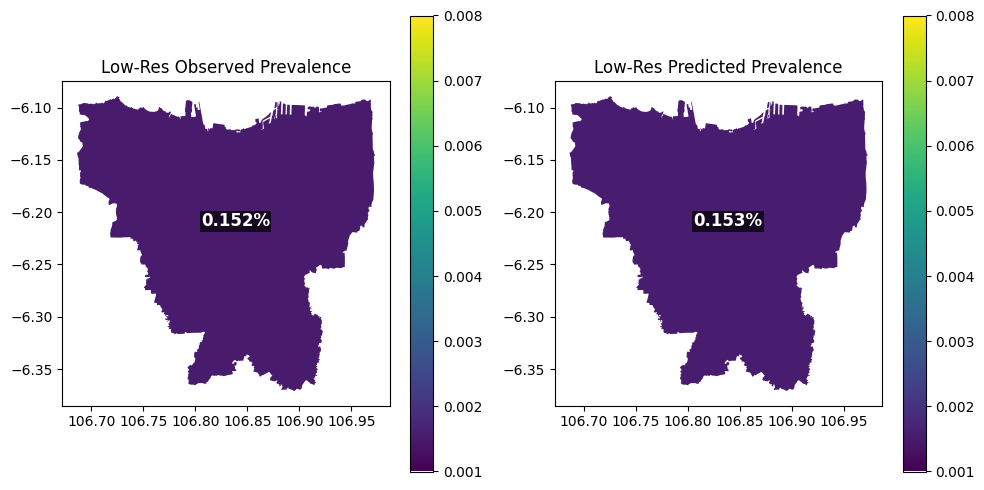

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

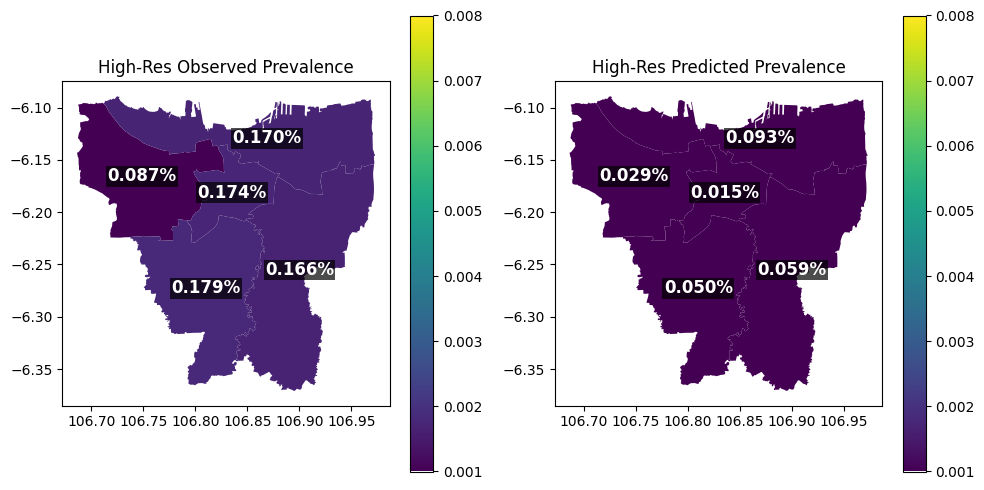

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [31]:
#save the df predictions (change the year naming convention manually)
#df_hi.to_csv("df_hi_jkt_2023_aggVAE_preds.csv")

### MCMC 2 (z = 40, n = 1000 Inference, target accept prob = 0.85) - 2023, batch size 5

In [ ]:
args["z_dim"] = 40
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [ ]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [ ]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},)

# %%
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     98.00      8.35    102.25     83.52    103.97      2.03      8.34
             b_hdi     -1.91      0.95     -1.61     -3.23     -0.74      2.03     13.36
     b_pop_density      1.41      1.12      1.13      0.38      3.39      2.02     13.86
           b_urban     -2.47      0.95     -2.62     -3.53     -1.00      2.08      6.05
full_pred_cases[0]   1221.88     11.69   1220.86   1202.17   1236.73      2.20      4.09
full_pred_cases[1]     52.94     69.71     32.94     -9.78    167.74      2.01     20.86
full_pred_cases[2]     11.33     18.99      5.03     -6.56     43.75      2.05     10.22
full_pred_cases[3]     80.16     83.46     54.92     -0.06    209.24      2.00     41.60
full_pred_cases[4]    140.70    124.22    122.93     -1.65    308.16      2.00     51.10
full_pred_cases[5]    133.69     98.08    135.33     -1.81    261.08      2.00     53.05
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1221.885,11.692,1201.521,1238.442,5.626,2.271,5.0,19.0,2.68
pred_cases_out[1],52.935,69.711,-10.311,168.027,34.665,17.301,5.0,14.0,2.85
pred_cases_out[2],11.328,18.987,-8.259,43.751,9.406,5.175,5.0,19.0,2.92
pred_cases_out[3],80.155,83.460,1.261,212.900,41.550,16.844,5.0,16.0,2.66
pred_cases_out[4],140.702,124.223,-3.449,308.242,61.850,17.760,4.0,14.0,3.25
pred_cases_out[5],133.692,98.076,-3.801,261.082,48.832,18.873,5.0,18.0,3.09
lp[0],1220.010,8.680,1204.265,1236.445,3.090,1.073,8.0,40.0,1.47
lp[1],53.606,65.315,0.000,161.617,32.515,16.119,4.0,4.0,4.17
lp[2],11.517,19.983,0.000,47.965,9.943,5.795,4.0,4.0,4.26
lp[3],74.816,83.355,0.000,203.371,41.501,16.880,4.0,4.0,4.07


In [ ]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 2
Average ESS for all aggVAE-low effects : 2
Max r_hat for all aggVAE-low : 6.409999847412109
Average ESS for all aggVAE-high effects : 2
Max r_hat for all aggVAE-high : 6.070000171661377


In [ ]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
#calculate RMSE, MAE, MAPE / MAE as percentage of average no. of districts
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract the predicted and observed values
y_pred = df_hi["pred_cases"].values
y_true = df_hi["incidence"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Group by district
district_mae_pct = []

for district, group in df_hi.groupby("District"):
    y_true_d = group["incidence"].values
    y_pred_d = group["pred_cases"].values

    if len(y_true_d) > 0 and np.mean(y_true_d) != 0:
        mae_d = mean_absolute_error(y_true_d, y_pred_d)
        mae_pct_d = (mae_d / np.mean(y_true_d)) * 100
        district_mae_pct.append(mae_pct_d)

# Average across districts
mae_pct_avg_across_districts = np.mean(district_mae_pct)

ccc = concordance_correlation_coefficient(y_true, y_pred)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_across_districts:.2f}%")
print(f"CCC: {ccc:.4f}")

RMSE: 0.0011
MAE as % of average observed prevalence: 68.05%
CCC: 0.0476


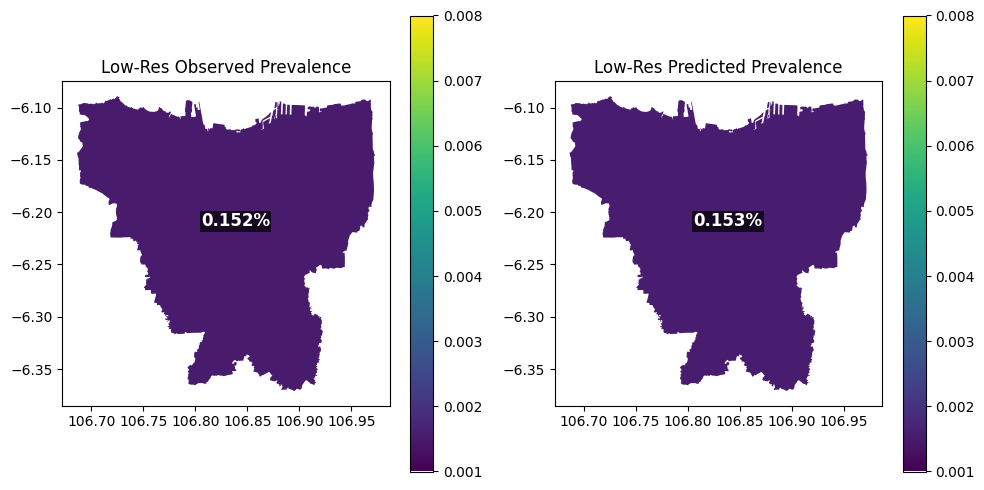

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

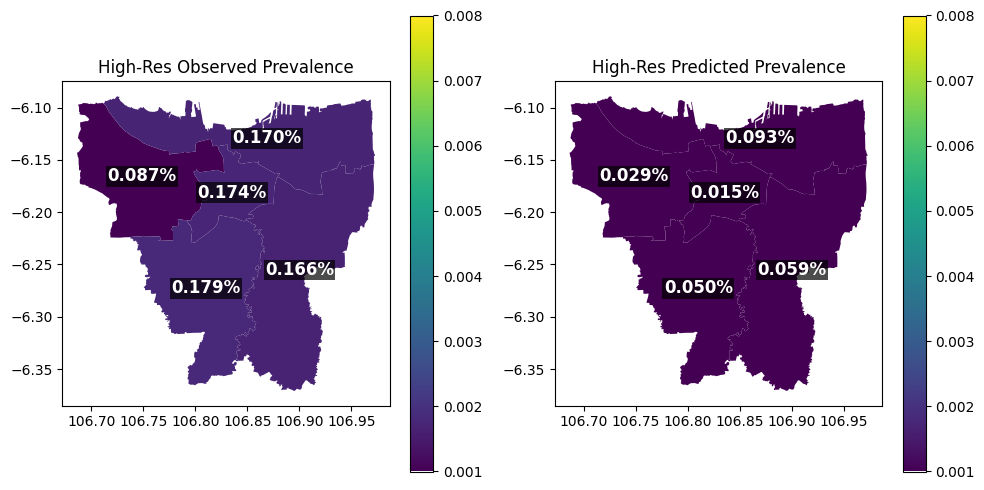

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
#save the df predictions (change the year naming convention manually)
#df_hi.to_csv("df_hi_jkt_2023_aggVAE_preds.csv")

### MCMC 3 (z = 40, n = 1000) - 2023, batch size 5

In [ ]:
df_hi = gpd.read_file("../data/processed/jkt_dist.shp")
df_lo = gpd.read_file("../data/processed/jkt_prov.shp")

df_hi = df_hi[df_hi["Year"] == 2023]
df_lo = df_lo[df_lo["Year"] == 2023]

df_hi["incidence"] = df_hi["Cases"] / df_hi["Population"]
df_lo["incidence"] = df_lo["Cases"] / df_lo["Population"]

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

In [303]:
args["z_dim"] = 40
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [304]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [305]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_3.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_3,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_3.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.26      9.83     99.68     83.72    114.89     61.90      1.05
             b_hdi     -0.37      1.10     -0.33     -2.23      1.46      8.57      1.27
     b_pop_density      0.33      0.97      0.32     -1.21      1.91     35.71      1.10
           b_urban     -0.31      1.39     -0.11     -2.67      1.56      3.49      1.64
full_pred_cases[0]   1557.16     13.36   1560.03   1539.70   1576.54     11.21      1.40
full_pred_cases[1]    214.16    183.06    176.60    -11.40    429.02      2.31      2.86
full_pred_cases[2]    126.64    146.01      8.37    -13.09    326.79      2.54      2.22
full_pred_cases[3]    257.65    203.07    212.67    -11.23    490.37      2.24      3.12
full_pred_cases[4]    339.13    237.29    334.41    -13.65    586.18      2.16      3.75
full_pred_cases[5]    332.03    211.15    393.10     -9.20    543.93      2.27      3.02
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1557.161,13.365,1524.115,1576.543,4.291,4.554,18.0,17.0,1.19
pred_cases_out[1],214.156,183.055,-13.123,466.704,84.566,15.922,5.0,28.0,2.04
pred_cases_out[2],126.636,146.013,-18.084,353.392,63.819,8.875,7.0,36.0,1.61
pred_cases_out[3],257.647,203.067,-13.528,525.974,95.191,23.445,5.0,58.0,2.10
pred_cases_out[4],339.133,237.288,-15.512,635.931,113.318,40.538,5.0,27.0,2.10
pred_cases_out[5],332.030,211.151,-10.150,582.005,98.536,38.692,6.0,22.0,2.04
lp[0],1559.488,8.428,1543.307,1576.077,2.291,2.280,21.0,14.0,1.14
lp[1],214.571,182.556,0.000,465.974,84.342,15.970,5.0,4.0,2.23
lp[2],127.030,145.658,0.000,344.522,63.640,8.902,6.0,5.0,1.98
lp[3],257.442,203.123,0.000,525.424,95.288,23.453,5.0,4.0,2.24


In [306]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_3.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 5
Average ESS for all aggVAE-low effects : 5
Max r_hat for all aggVAE-low : 1.3799999952316284
Average ESS for all aggVAE-high effects : 4
Max r_hat for all aggVAE-high : 1.590000033378601


### MCMC 3 (z = 40, n = 1000) - 2023, batch size 100

In [307]:
args["z_dim"] = 40
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [308]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [309]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_7.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_7,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_7.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    102.49     11.96    103.78     85.09    116.84      2.00     47.46
             b_hdi     -0.04      1.13      0.38     -1.97      1.03      2.01     21.86
     b_pop_density      0.12      0.65      0.38     -0.99      0.69      2.01     20.33
           b_urban     -1.09      1.02     -0.84     -2.80      0.00      2.05      7.04
full_pred_cases[0]   1571.17     10.64   1571.71   1549.49   1583.00      5.30      1.61
full_pred_cases[1]     58.13     99.78     15.12    -27.80    228.12      2.00    180.88
full_pred_cases[2]     16.47     39.62      4.46    -19.28     84.02      2.02     18.40
full_pred_cases[3]     75.47    123.46     12.61     -5.57    288.77      2.00     90.15
full_pred_cases[4]    117.87    160.22     46.26     -8.78    389.85      2.00    244.22
full_pred_cases[5]    182.90    126.00    152.72     44.48    382.38      2.00    168.41
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1571.171,10.639,1541.461,1583.036,4.005,3.210,7.0,17.0,1.98
pred_cases_out[1],58.134,99.781,-27.805,228.696,49.690,27.813,5.0,19.0,3.14
pred_cases_out[2],16.469,39.624,-23.626,85.528,19.700,10.099,5.0,15.0,2.99
pred_cases_out[3],75.472,123.457,-5.579,290.024,61.477,35.338,4.0,13.0,3.61
pred_cases_out[4],117.867,160.222,-8.772,390.995,79.789,44.053,4.0,12.0,3.85
pred_cases_out[5],182.901,125.998,43.009,382.504,62.745,29.776,4.0,11.0,3.51
lp[0],1571.111,13.858,1544.985,1599.719,3.861,1.895,13.0,30.0,1.23
lp[1],57.088,98.894,0.000,229.270,49.248,28.431,5.0,4.0,3.22
lp[2],20.193,34.992,0.000,81.994,17.420,10.065,5.0,4.0,3.30
lp[3],71.560,123.963,0.000,287.246,61.732,35.638,4.0,4.0,3.73


In [310]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_7.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 2
Average ESS for all aggVAE-low effects : 2
Max r_hat for all aggVAE-low : 28.40999984741211
Average ESS for all aggVAE-high effects : 2
Max r_hat for all aggVAE-high : 35.720001220703125


### batch size = 5 is superior. now change target accept prob to see which one converges the best

In [ ]:
df_hi = gpd.read_file("../data/processed/jkt_dist.shp")
df_lo = gpd.read_file("../data/processed/jkt_prov.shp")

#filer to get year 2020
df_hi = df_hi[df_hi["Year"] == 2020]
df_lo = df_lo[df_lo["Year"] == 2020]

df_hi["incidence"] = df_hi["Cases"] / df_hi["Population"]
df_lo["incidence"] = df_lo["Cases"] / df_lo["Population"]

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

### MCMC (z = 40, n = 1000, target accept prob = 0.9) - year is 2020

In [312]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_6.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_6,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_6.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.77      9.80     99.77     83.49    115.36   2482.36      1.00
             b_hdi      0.07      1.01      0.05     -1.63      1.62   1425.00      1.00
     b_pop_density      0.08      1.00      0.07     -1.67      1.66   2048.05      1.00
           b_urban      0.06      1.00      0.05     -1.59      1.69   1120.81      1.00
full_pred_cases[0]   1216.77      7.98   1216.88   1203.54   1229.52   1927.13      1.00
full_pred_cases[1]    274.03    133.15    270.33     50.83    487.39    397.99      1.00
full_pred_cases[2]    169.16    131.08    158.45    -11.09    347.88    484.94      1.00
full_pred_cases[3]    317.93    138.55    317.93     90.07    536.97    390.66      1.00
full_pred_cases[4]    405.41    139.81    405.22    186.72    616.64    373.36      1.00
full_pred_cases[5]    388.67    133.75    380.11    177.67    568.62    429.71      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1216.769,7.976,1199.842,1231.419,0.181,0.295,2215.0,1422.0,1.01
pred_cases_out[1],274.033,133.151,-7.207,478.273,6.522,5.152,416.0,590.0,1.00
pred_cases_out[2],169.158,131.080,-13.369,384.459,5.866,3.284,480.0,1002.0,1.00
pred_cases_out[3],317.935,138.554,-4.231,526.368,6.841,4.869,416.0,594.0,1.00
pred_cases_out[4],405.412,139.808,163.292,683.346,7.058,6.835,414.0,582.0,1.00
pred_cases_out[5],388.666,133.754,139.504,603.278,6.376,10.644,512.0,643.0,1.00
lp[0],1216.793,5.732,1205.773,1228.997,0.116,0.176,2698.0,1912.0,1.01
lp[1],273.955,133.087,0.000,471.599,6.526,5.161,419.0,587.0,1.00
lp[2],169.105,130.981,0.000,383.309,5.864,3.282,456.0,643.0,1.00
lp[3],317.926,138.388,0.000,517.400,6.832,4.866,417.0,583.0,1.00


In [313]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_6.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 1195
Average ESS for all aggVAE-low effects : 1209
Max r_hat for all aggVAE-low : 1.0
Average ESS for all aggVAE-high effects : 1192
Max r_hat for all aggVAE-high : 1.0


In [314]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [315]:
#calculate RMSE, MAE, MAPE / MAE as percentage of average no. of districts
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract the predicted and observed values
y_pred = df_hi["pred_cases"].values
y_true = df_hi["incidence"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Group by district
district_mae_pct = []

for district, group in df_hi.groupby("District"):
    y_true_d = group["incidence"].values
    y_pred_d = group["pred_cases"].values

    if len(y_true_d) > 0 and np.mean(y_true_d) != 0:
        mae_d = mean_absolute_error(y_true_d, y_pred_d)
        mae_pct_d = (mae_d / np.mean(y_true_d)) * 100
        district_mae_pct.append(mae_pct_d)

# Average across districts
mae_pct_avg_across_districts = np.mean(district_mae_pct)

ccc = concordance_correlation_coefficient(y_true, y_pred)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_across_districts:.2f}%")
print(f"CCC: {ccc:.4f}")

RMSE: 0.0006
MAE as % of average observed prevalence: 34.96%
CCC: 0.3546


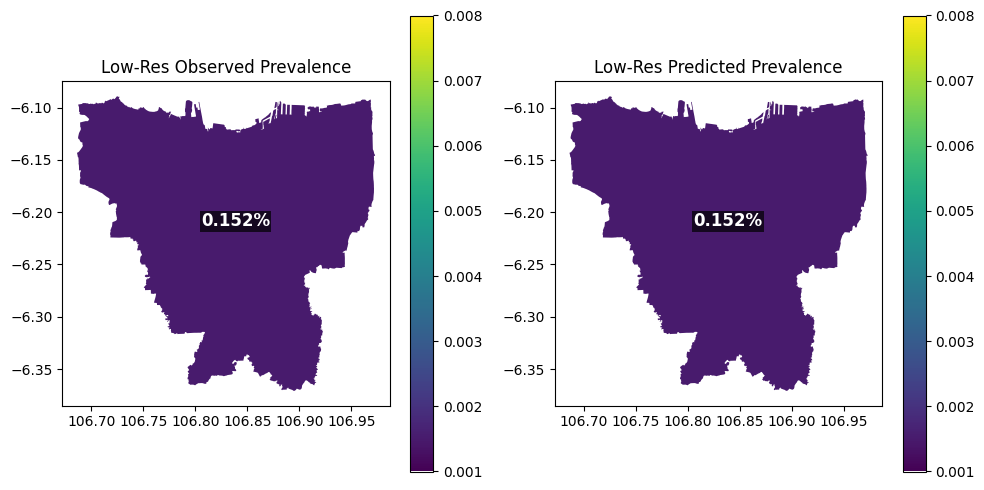

In [316]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

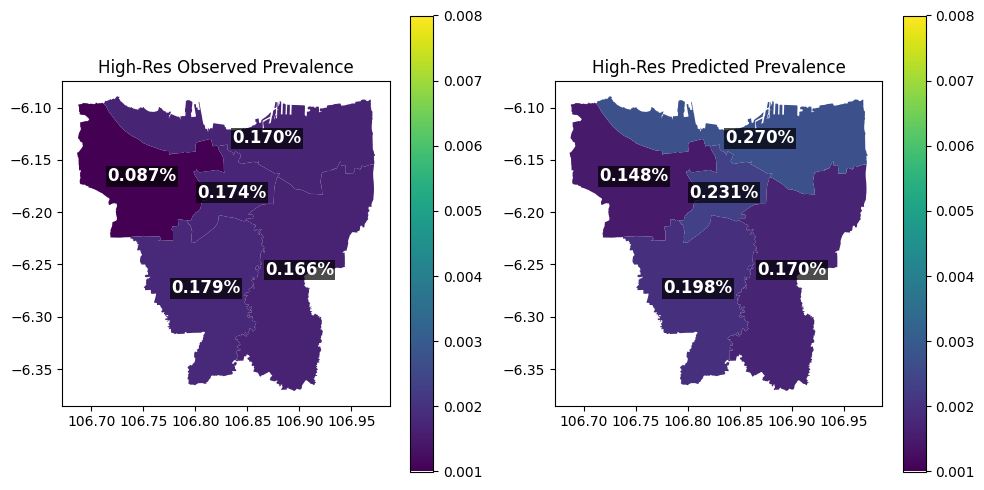

In [317]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

### MCMC (z = 40, n = 1000, target accept prob = 0.85) - year is 2020

In [ ]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_5.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]

numpyro_data = az.from_numpyro(
    mcmc_5,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},)

numpyro_data = az.from_numpyro(
    mcmc_1,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={
        "pred_cases": ["district"],      # <--- observed site
        "pred_cases_out": ["district"],   # <--- predictive site
        "lp": ["district"],               # <--- latent predictor
        "vae": ["district"],              # <--- decoder output
    },
)
print(mcmc_5.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.20      9.68    100.50     85.43    117.30   2867.23      1.00
             b_hdi      0.03      0.99      0.02     -1.58      1.66   1161.22      1.00
     b_pop_density      0.14      0.98      0.13     -1.57      1.60    833.38      1.01
           b_urban      0.11      1.02      0.12     -1.48      1.85    883.30      1.01
full_pred_cases[0]   1217.31      8.32   1217.21   1203.62   1229.71   1908.75      1.00
full_pred_cases[1]    267.76    132.47    267.42     36.46    467.38    377.31      1.02
full_pred_cases[2]    162.08    132.34    152.04    -10.87    345.49    430.28      1.02
full_pred_cases[3]    309.39    137.69    311.11     72.03    512.51    316.53      1.02
full_pred_cases[4]    397.71    137.44    400.11    134.48    583.66    276.42      1.03
full_pred_cases[5]    387.74    129.27    375.47    171.79    578.67    504.53      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1217.305,8.318,1200.243,1233.839,0.191,0.294,1697.0,1319.0,1.01
pred_cases_out[1],267.759,132.469,-8.339,482.310,6.845,3.877,370.0,566.0,1.02
pred_cases_out[2],162.083,132.345,-14.882,393.298,6.409,3.406,449.0,596.0,1.02
pred_cases_out[3],309.387,137.693,53.542,573.570,7.719,4.463,328.0,319.0,1.02
pred_cases_out[4],397.707,137.436,134.477,650.721,8.293,5.416,289.0,73.0,1.03
pred_cases_out[5],387.742,129.271,157.349,645.014,5.754,4.773,543.0,547.0,1.01
lp[0],1216.999,5.986,1204.915,1229.560,0.113,0.192,2906.0,1867.0,1.01
lp[1],267.600,132.457,0.000,480.766,6.876,3.888,370.0,565.0,1.02
lp[2],161.622,132.848,0.000,389.967,6.589,3.421,246.0,124.0,1.03
lp[3],309.321,137.923,55.022,572.647,7.906,4.610,314.0,167.0,1.02


In [319]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_5.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 741
Average ESS for all aggVAE-low effects : 765
Max r_hat for all aggVAE-low : 1.0099999904632568
Average ESS for all aggVAE-high effects : 736
Max r_hat for all aggVAE-high : 1.0099999904632568


In [320]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [321]:
#calculate RMSE, MAE, MAPE / MAE as percentage of average no. of districts
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract the predicted and observed values
y_pred = df_hi["pred_cases"].values
y_true = df_hi["incidence"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Group by district
district_mae_pct = []

for district, group in df_hi.groupby("District"):
    y_true_d = group["incidence"].values
    y_pred_d = group["pred_cases"].values

    if len(y_true_d) > 0 and np.mean(y_true_d) != 0:
        mae_d = mean_absolute_error(y_true_d, y_pred_d)
        mae_pct_d = (mae_d / np.mean(y_true_d)) * 100
        district_mae_pct.append(mae_pct_d)

# Average across districts
mae_pct_avg_across_districts = np.mean(district_mae_pct)

ccc = concordance_correlation_coefficient(y_true, y_pred)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_across_districts:.2f}%")
print(f"CCC: {ccc:.4f}")

RMSE: 0.0006
MAE as % of average observed prevalence: 32.01%
CCC: 0.3732


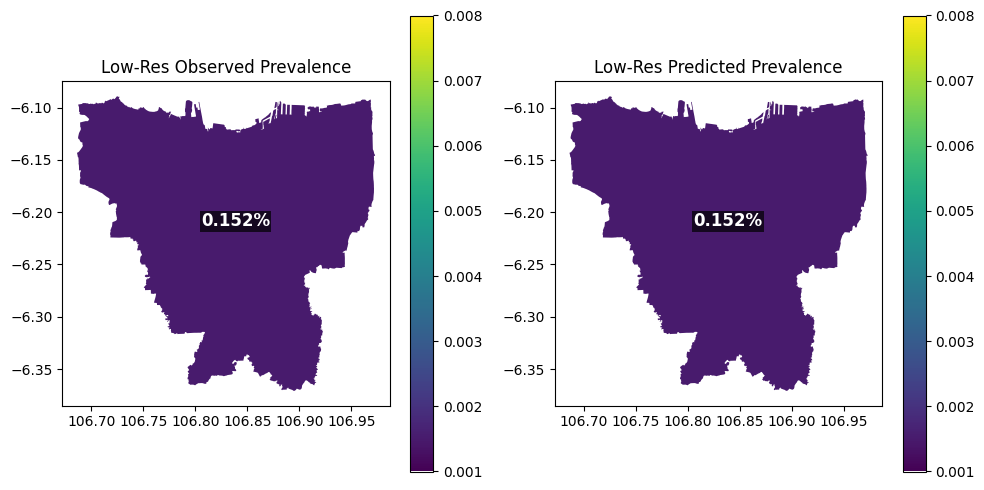

In [322]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

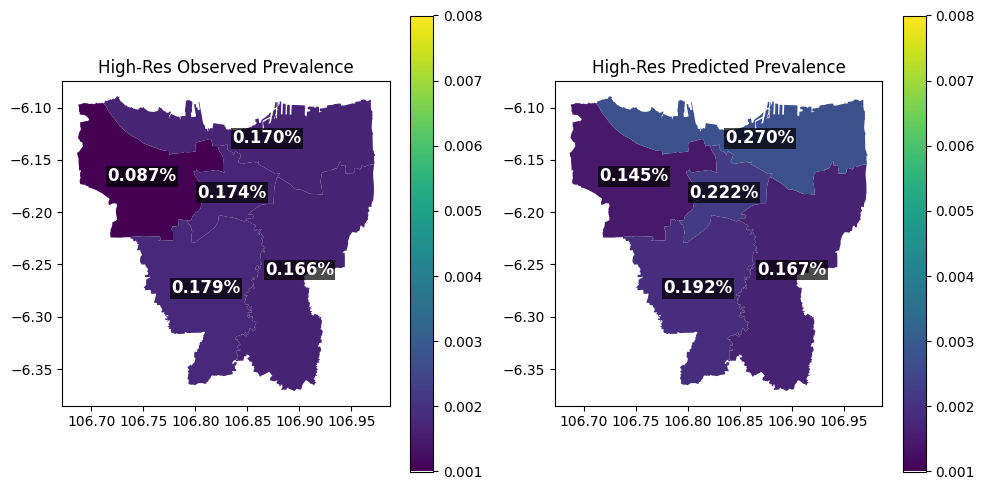

In [323]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [324]:
#save the df predictions (change the year naming convention manually)
#df_hi.to_csv("../data/processed/df_hi_jkt_2020_aggVAE_preds.csv")